In [ ]:
Objective : To deterimine anomalies in comment present in each topic .Used DBSCAN as it is robust towrads outliers and doesn't require to pre define the no. of clusters.

Conclusion : Mostly for all topics the , DBSCAN generated very few clusters 1,2,3 along with the anomalies for each topic had similiar kind of features as observed in anomalies but narration would be different, can have Malay words transliterated into English words.

Approach: Did pre-processing on comments then obtained pooled bert embeddings,we perform scaling and then feed those embeddings to DBSCAN model.To determine the amount of Anomalies.
1)To create DBSCAN model we require to input two parameters- min samples and epsilon.Epsilon using K-distance  
Min_ samples should be atleast greater than features.but here the feature counts is 768 and sample counts is 600 in cluster 13 .Hence if we take it 769 so all points shall come in one cluster
.We started providing a range of values starting from 1/10th sample 50 ,70, 90, but results no. of clusters changes from 2-3. Objective was to to take in loop an increment of 
1/5 th sample and then find out which min sample produces the maximum no. of cluster.Since we wanted to follow the same approach of not having to high or low min samples as clusters may be very low or very high .

2)Another approach would to use grid search with metric as sihoutte score

But since we wanted to focus on anomalies, and the base models mostly had 1 , 2, 3, clusters.Need to evaluate the clusters of DBSCAN so used 
silhoutte score , but in many topics only two clusters were there 0 & -1 , -1 are discareded while obtaining silhoutte score, hence cannot evaluate the silhoutte score. Hence thought of other approach density based approach  i.e. local outlier factor.

Secondly the issue with DBSCAN is that if it says any data point as anomaly , mostly baseed on manual observation that data does not contain topic words.But we have seen that context or same anchor information present in clusters, it's just contains additional narration differs.
Anomalies like match date of incorporation, mismatch business registration number and date of incorporation., presence of malay entities etc.
Mostly the anomalies comments didn't contain associated the topic words.
Now also observed that for topics the anomalies had decsription about one particular anchor which may not be present in other clusters.
So no specific features were obatined from Anomaly detection.



Started using DB

In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import word2vec
import numpy as np
import pandas as pd
import ast
import re
import torch
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [7]:
# import dataiku
import os

In [10]:
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# path_folder=os.path.join(folder_path,"Output_of_topic_modelling_final_20_bi_tri_2.csv")
df=pd.read_csv("Output_of_topic_modelling_final_20_bi_tri_2.csv")


In [11]:
df.head()
df.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace=True)

In [12]:
df

,V_COMMENTS,Counts,V_COMMENTS_2,Tokens,id_2_feature,TFIDF_Feature,Topic_tfidf_lda,All_Topic_tfidf_Probabilities,TF_tfidf_Topic_No,TF IDF Topic words
0,mismatch id number_nric,67150,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.03744973), (2, 0.0373...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
1,mismatch id number_nric\n,40137,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.037449747), (2, 0.037...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
2,mismatch year of birth (yob),27341,mismatch year birth yob,"['mismatch', 'year', 'birth', 'yob']","[(2, 1), (5, 1), (6, 1), (7, 1)]","[(2, 0.06249879031496278), (5, 0.5453915180875...","0.162*""yob"" + 0.111*""year"" + 0.073*""birth"" + 0...","[(0, 0.038604278), (1, 0.038610753), (2, 0.038...",3,"['yob', 'year', 'birth', 'infer', 'bear', 'ref..."
3,mismatch id number_nric,25793,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.037449766), (2, 0.037...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
4,mismatch full legal name – name does not sound...,19127,mismatch full name sound similar,"['mismatch', 'full', 'name', 'sound', 'similar']","[(2, 1), (8, 1), (9, 1), (10, 1), (11, 1)]","[(2, 0.030451784805766515), (8, 0.473060193932...","0.137*""name"" + 0.051*""match"" + 0.039*""full"" + ...","[(0, 0.037577048), (1, 0.040632684), (2, 0.037...",17,"['name', 'match', 'full', 'passport', 'similar..."
...,...,...,...,...,...,...,...,...,...,...
221569,"mismatch - name, nric, date of birth, profile,...",1,mismatch name nric date birth profile customer...,"['mismatch', 'name', 'nric', 'date', 'birth', ...","[(2, 1), (3, 3), (4, 1), (5, 3), (9, 3), (12, ...","[(2, 0.005990920965347929), (3, 0.227682171168...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.02934474), (1, 0.031117253), (2, 0.0294...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221570,"mismatch - name, nric, date of birth, profile,...",1,mismatch name nric date birth profile customer...,"['mismatch', 'name', 'nric', 'date', 'birth', ...","[(2, 1), (3, 3), (4, 1), (5, 3), (9, 3), (12, ...","[(2, 0.0085888069800516), (3, 0.32641362359475...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.031628136), (1, 0.033863842), (2, 0.031...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221571,mismatch id number_nric. watch person (noraini...,1,mismatch id number nric watch person bank cus...,"['mismatch', 'i', 'd', 'number', 'nric', 'watc...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (15, ...","[(0, 0.27243957135183583), (1, 0.2725518874840...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.03383267), (1, 0.033776768), (2, 0.0337...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221572,mismatch id number_nric. watch person (noraini...,1,mismatch id number nric watch person bank cus...,"['mismatch', 'i', 'd', 'number', 'nric', 'watc...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (15, ...","[(0, 0.27243957135183583), (1, 0.2725518874840...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.03383269), (1, 0.03377677), (2, 0.03370...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."


In [13]:
import calendar
cal=list(calendar.month_name)
for i in list(calendar.month_name[1:]):
    cal.append(i[:3])

In [14]:
patt1=re.compile("Match ID and/or Full Legal Name",re.IGNORECASE)
# patt2=re.compile("Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment")
patt2=re.compile("(Agreed|agree) (to|with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation|is recommendation)",re.IGNORECASE)
patt3=re.compile("Unknown|false hit\.*|true hit\.*|Rationale|Source",re.IGNORECASE)
patt4=re.compile("CSCDD7|CSCDD1|CSCDD4",re.IGNORECASE)
patt5=re.compile("SCC6|No further review is required by analyst|SC/DEL",re.IGNORECASE)
patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
patt7=re.compile("(%s)"%"|".join(cal)[1:],re.IGNORECASE)
patt8=re.compile("\s*(Mohd|NORAINI|ABDULLAH|BINTI|system|legal|stated|ABD|mahdzir|bin|khalid|siti|hajar|mohd|sallehudin|mohd|saddam|inie|binti|abdullah|noraini|norliza|binti|othman)\s*",re.IGNORECASE)


In [ ]:
df.dropna(inplace=True)

In [18]:

df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS"].apply(lambda x: re.sub("\n"," ",x)) #1

df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("Name – Name","Name",x))    #2
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("Name_Name","Name",x))      #3
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("\s*_\s*|\s*-\s*"," ",x)) #4,5
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt1)==False] #7
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt2,"",x)) #8
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt3,"",x))  #  9
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt4)==False]        # 10
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt5)==False]       #11
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt6,"",x)) #15
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("[^\w\s\.]|\d","",x))
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("\d*","",x))    #date, year, accounts 6
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt7,"",x))    # month 6
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt8," ",x)) # 17


In [19]:
df=df[df["V_COMMENTS_PROCESSED"].apply(lambda x : len(x)!=0)]
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].str.lower()


In [20]:
df["V_COMMENTS_PROCESSED"]

0                                   mismatch id number nric
1                                  mismatch id number nric 
2                                mismatch year of birth yob
3                                   mismatch id number nric
4           mismatch full name  name does not sound similar
                                ...                        
221569    mismatch name nric date of birth profile   cus...
221570    mismatch name nric date of birth profile   cus...
221571    mismatch id number nric. watch person    is a ...
221572    mismatch id number nric. watch person    is a ...
221573    mismatch profile as adverse news reported   de...
Name: V_COMMENTS_PROCESSED, Length: 221574, dtype: object

In [15]:
df_groups=df.groupby("TF_tfidf_Topic_No")
df["TF_tfidf_Topic_No"].value_counts().sort_values(ascending=False)

TF_tfidf_Topic_No
6     41846
3     31042
14    25252
4     18335
8     15784
5     13528
10    12982
17    10520
16     9395
0      9348
1      8627
9      6395
12     5418
11     4608
19     2773
7      1916
15     1124
2      1070
18      953
13      658
Name: count, dtype: int64

In [147]:
# df["Comments_Processed"]
# max_length=max(df["V_COMMENTS_TOKENS"].apply(lambda x: len(x)))

In [24]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
model=BertModel.from_pretrained("bert-base-uncased")

In [22]:
# Function to process a single pair of sentences and return the CLS token embedding
def process_pair(sentence1):
    # Tokenize sentences and add special tokens
    tokens = tokenizer(sentence1,return_tensors='pt', padding=True, truncation=True)
    
    # Pass tokenized input to BERT model to obtain CLS token embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Extract CLS token embeddings
    cls_embedding = outputs.pooler_output
    
    return cls_embedding


## DBSACN - 13

In [159]:
df_13=df_groups.get_group(13)
# vectors=embeddings

In [160]:
embeddings = []
for _, row in df_groups.get_group(13).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

# Stack the embeddings into a single tensor
# embeddings_tensor = torch.stack(embeddings)



In [161]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [162]:
# Scaling of embeddings

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)



In [ ]:
with scaling

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=4)   # We first
nbrs = neigh.fit(embeddings_arr)

In [ ]:
without scaling

K-distance plot - Here we determine the top few neighbours and therir distances from every data point.Now sort them at feature /column manner in asceding order.Pick the first column and plot is against data points.Now where curvature changes sharply , becomes our choise of k/ epsilon

In [29]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)   # We first
nbrs = neigh.fit(embeddings_arr)


In [30]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [31]:
indices

array([[ 25,   8,  14,   0],
       [ 89,   1,   6, 331],
       [  2,  42, 153,  72],
       ...,
       [655, 656, 654, 657],
       [656, 654, 657, 655],
       [657, 654, 656, 655]], dtype=int64)

In [34]:
x=np.array([[8,5,6],[8,6,3],[7,3,1]])
np.sort(x,axis=0)

array([[7, 3, 1],
       [8, 5, 3],
       [8, 6, 6]])

In [32]:
distances

array([[9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07],
       [1.11828226e-06, 1.11828226e-06, 1.11828226e-06, 1.11828226e-06],
       [7.90744970e-07, 6.83394463e-01, 6.83394463e-01, 6.83394463e-01],
       ...,
       [1.06624030e-06, 5.11985971e-01, 5.33486902e-01, 5.66732931e-01],
       [1.16800773e-06, 5.59976520e-02, 1.45095658e-01, 5.11985971e-01],
       [1.11828226e-06, 1.28114879e-01, 1.45095658e-01, 5.66732931e-01]])

`configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`


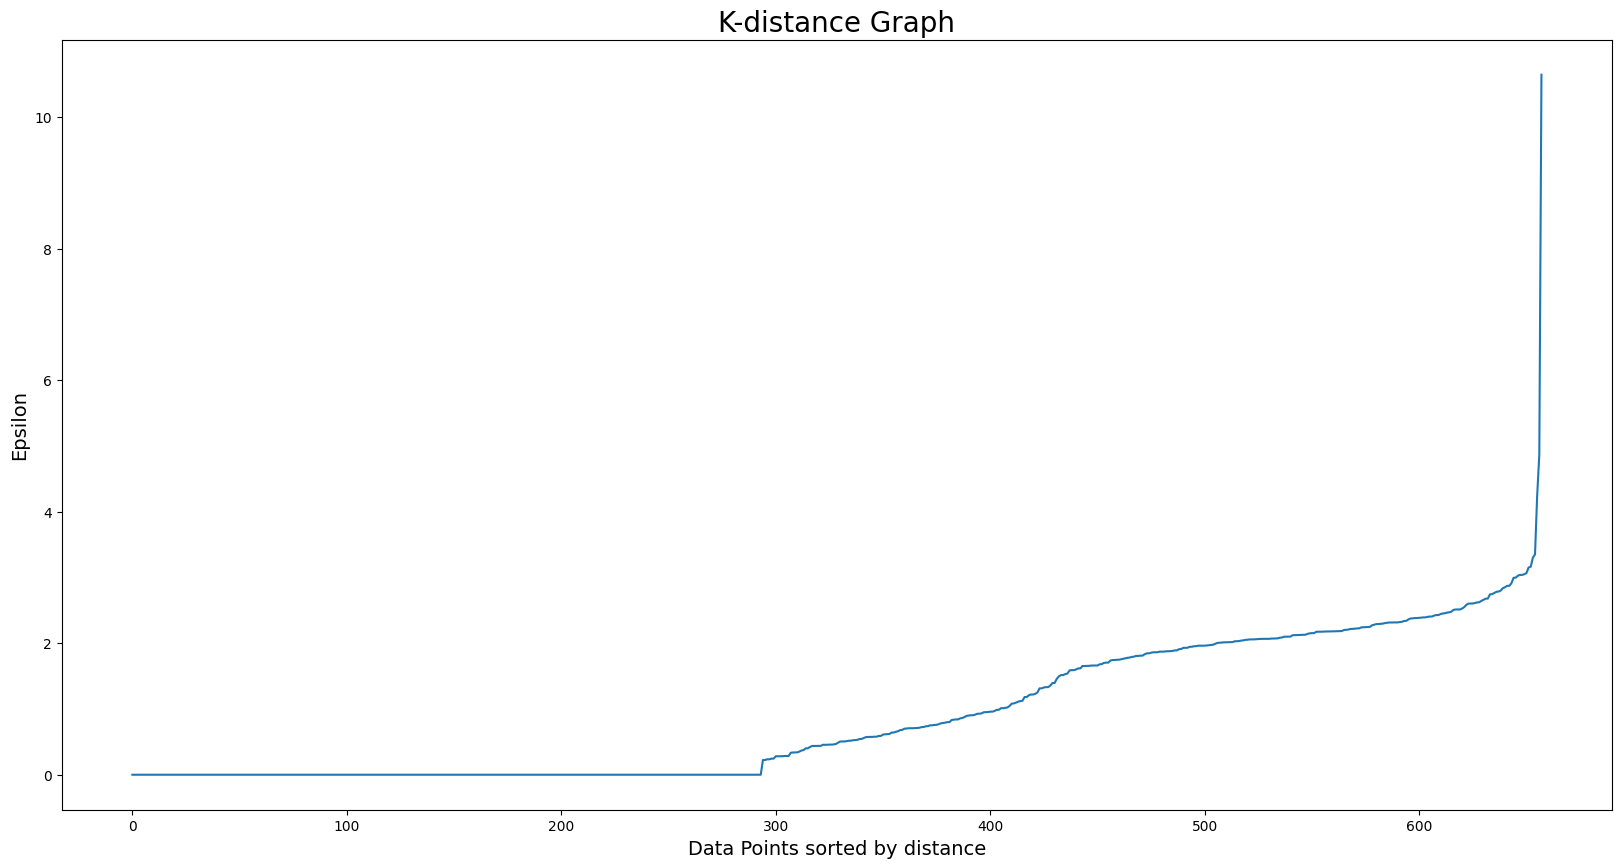

In [32]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [57]:

dbscan = DBSCAN(eps=4.0, min_samples=80)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [58]:
cluster_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0

In [59]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 26


In [62]:
df_13["Cluster_label"]=cluster_labels

In [63]:
df_13["Cluster_label"].unique()

array([ 0, -1], dtype=int64)

In [44]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder_13=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/13th_topic.csv")


df_13.to_csv(path_folder_13)


Silhoutte score calculation

In [75]:
# # Metric measurement - sihoutte score - we are suppose to remove the anomalies and then see the score.
# dbscan = DBSCAN(eps=0.3, min_samples=10)
# labels = dbscan.fit_predict(X)

# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_13[df_13["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")


Not enough clusters to calculate silhouette score


## DBSCAN -18

In [85]:
embeddings = []
for _, row in df_groups.get_group(18).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

df_18=df_groups.get_group(18)
vectors=embeddings
embeddings_arr_18=[i.numpy().flatten() for i in embeddings]

In [86]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [87]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [88]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [89]:
indices

array([[  0,  36, 375, 897],
       [ 11,   1, 593, 559],
       [  2, 711, 548, 494],
       ...,
       [950,  70, 365, 946],
       [951,   4, 178, 113],
       [952, 620, 406,  80]], dtype=int64)

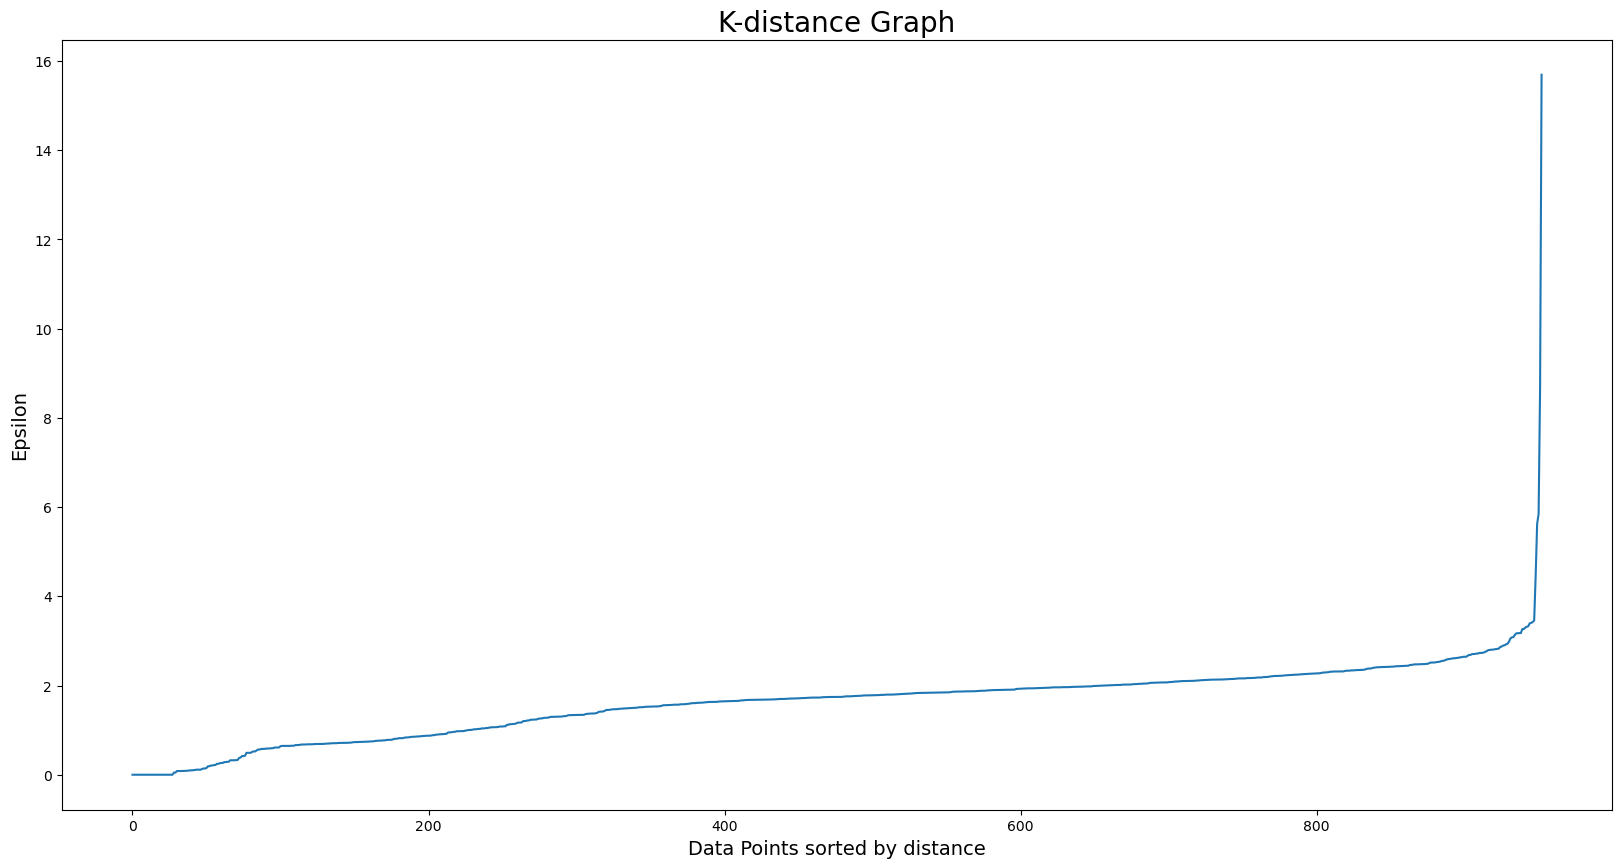

In [90]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [91]:

dbscan = DBSCAN(eps=3.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [92]:
cluster_labels

array([-1,  0, -1, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0, -1, -1, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [93]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 151


In [94]:
df_18["Cluster_label"]=cluster_labels

In [95]:
df_18["Cluster_label"].unique()

array([-1,  0], dtype=int64)

In [96]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_18[df_18["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

Not enough clusters to calculate silhouette score


In [97]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/18th_topic.csv")


In [98]:
df_18.to_csv(path_folder)

## DBSCAN -2

In [136]:
embeddings_2 = []
for _, row in df_groups.get_group(2).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings_2.append(cls_embedding)

In [137]:
df_2=df_groups.get_group(2)
vectors=embeddings_2

In [138]:
embeddings_arr_2=[i.numpy().flatten() for i in embeddings_2]

In [200]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [139]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr_2)


In [142]:
distances,indices=nbrs.kneighbors(embeddings_arr_2)


In [143]:
indices

array([[   0,  540, 1000,   98],
       [ 193,    1,  352,  362],
       [   2,   19,  550,  661],
       ...,
       [1067,  383,  204,  405],
       [1068,  322,  596,  614],
       [1069,  775, 1000,  265]], dtype=int64)

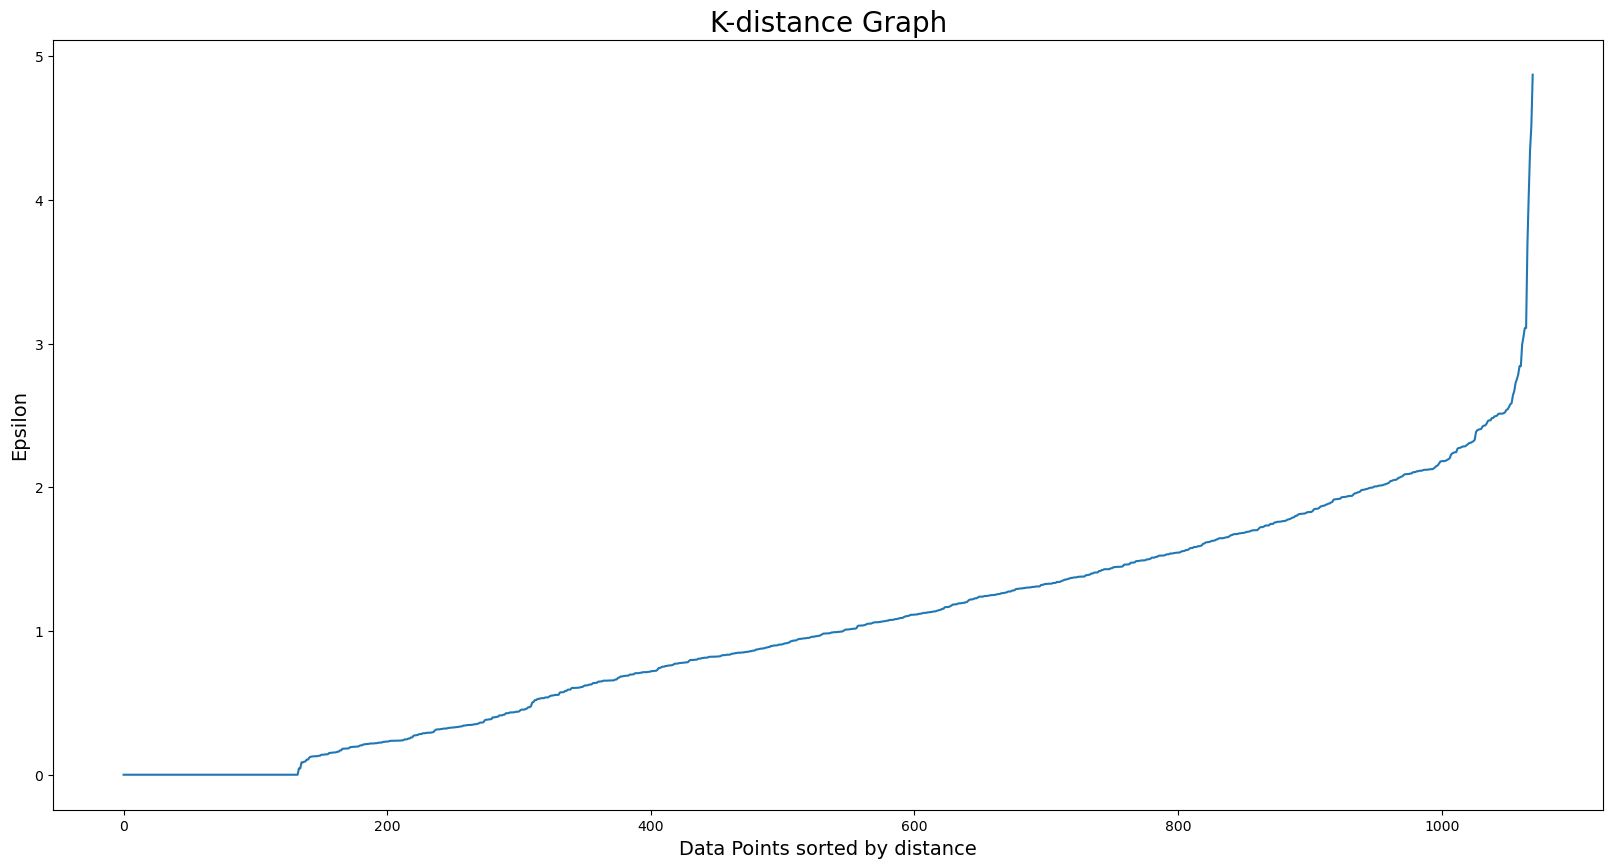

In [144]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [150]:

dbscan = DBSCAN(eps=2.0, min_samples=50)
dbscan.fit(embeddings_arr_2)
cluster_labels = dbscan.labels_
coords = embeddings_arr_2
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [151]:
cluster_labels

array([-1, -1, -1, ..., -1,  0, -1], dtype=int64)

In [152]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 401


In [153]:
df_2["Cluster_label"]=cluster_labels

In [157]:
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/2nd_topic.csv")
# df_2.to_csv(path_folder)

In [158]:
df_2.shape
df_2.to_csv("2nd_topic.csv")

In [ ]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_2[df_2["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

### DBSCAN -15

In [99]:
embeddings = []
for _, row in df_groups.get_group(15).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [100]:
df_15=df_groups.get_group(15)
vectors=embeddings

In [101]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [102]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [103]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [104]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [105]:
indices

array([[  18,   17,    9,    0],
       [  44,    1,  322,  327],
       [   2,  648,  646,  664],
       ...,
       [1121, 1122,  280,  687],
       [1122, 1121,  280,   81],
       [  41,   36,    7,    5]])

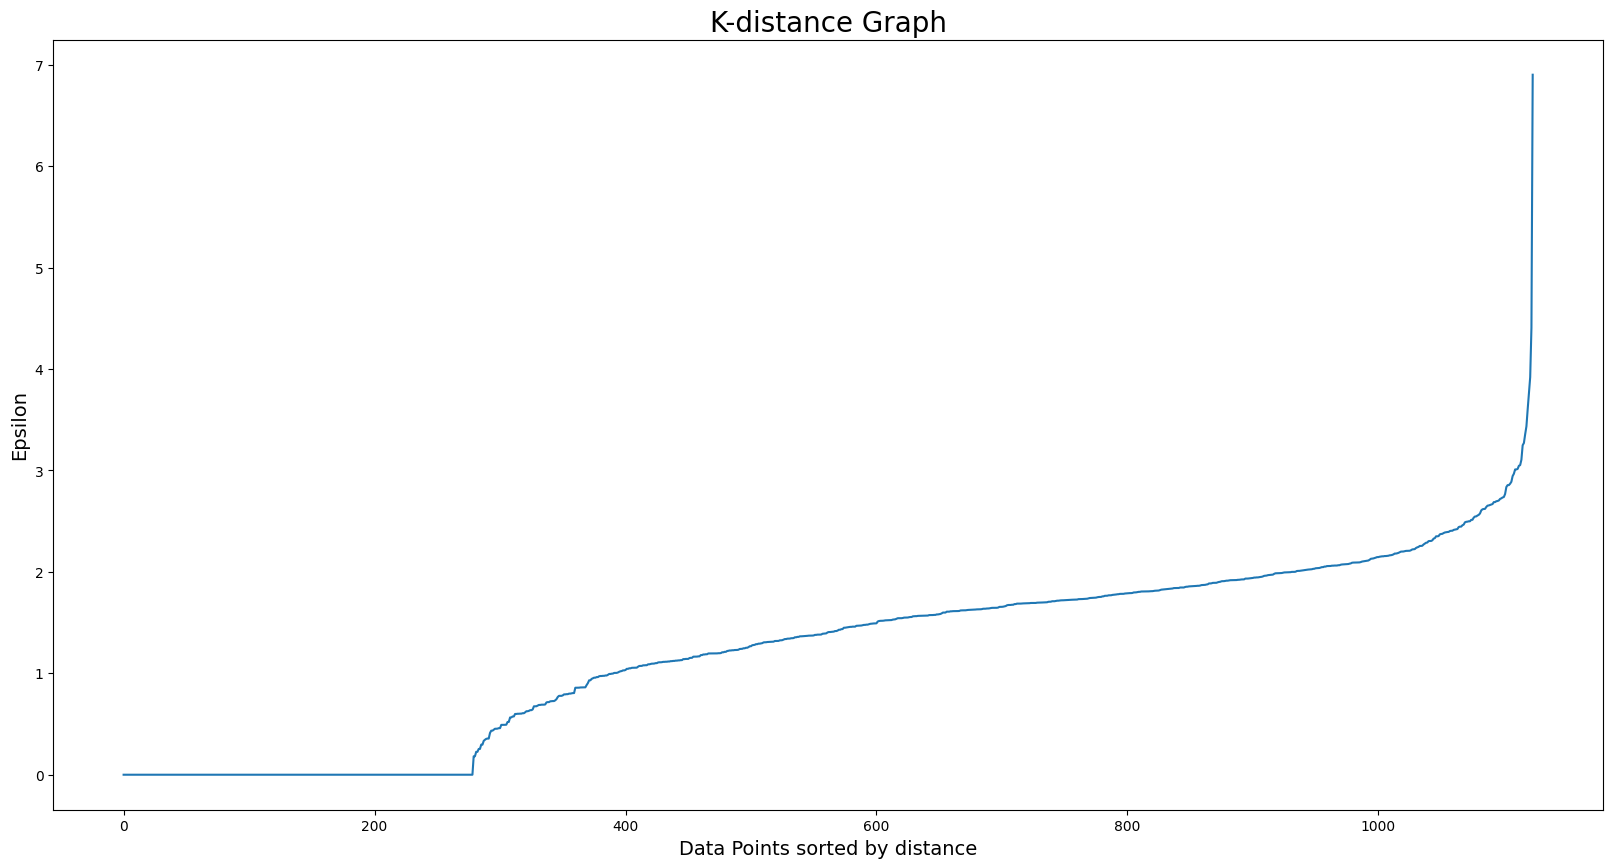

In [106]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [107]:

dbscan = DBSCAN(eps=3.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [108]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 108


In [110]:
df_15["Cluster_label"]=cluster_labels

In [111]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/15th_topic.csv")

df_15.to_csv(path_folder)

In [196]:
df_15.shape

(953, 13)

## DBSCAN -7

In [112]:
embeddings = []
for _, row in df_groups.get_group(7).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [113]:
df_7=df_groups.get_group(7)
vectors=embeddings

In [114]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [115]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [117]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [118]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [119]:
indices

array([[  36,    1,    7,    0],
       [  36,    1,    7,    0],
       [  23,    5,    2,  785],
       ...,
       [1913,  443, 1242, 1237],
       [ 125,  102,   83,   64],
       [ 354, 1915, 1014,  137]])

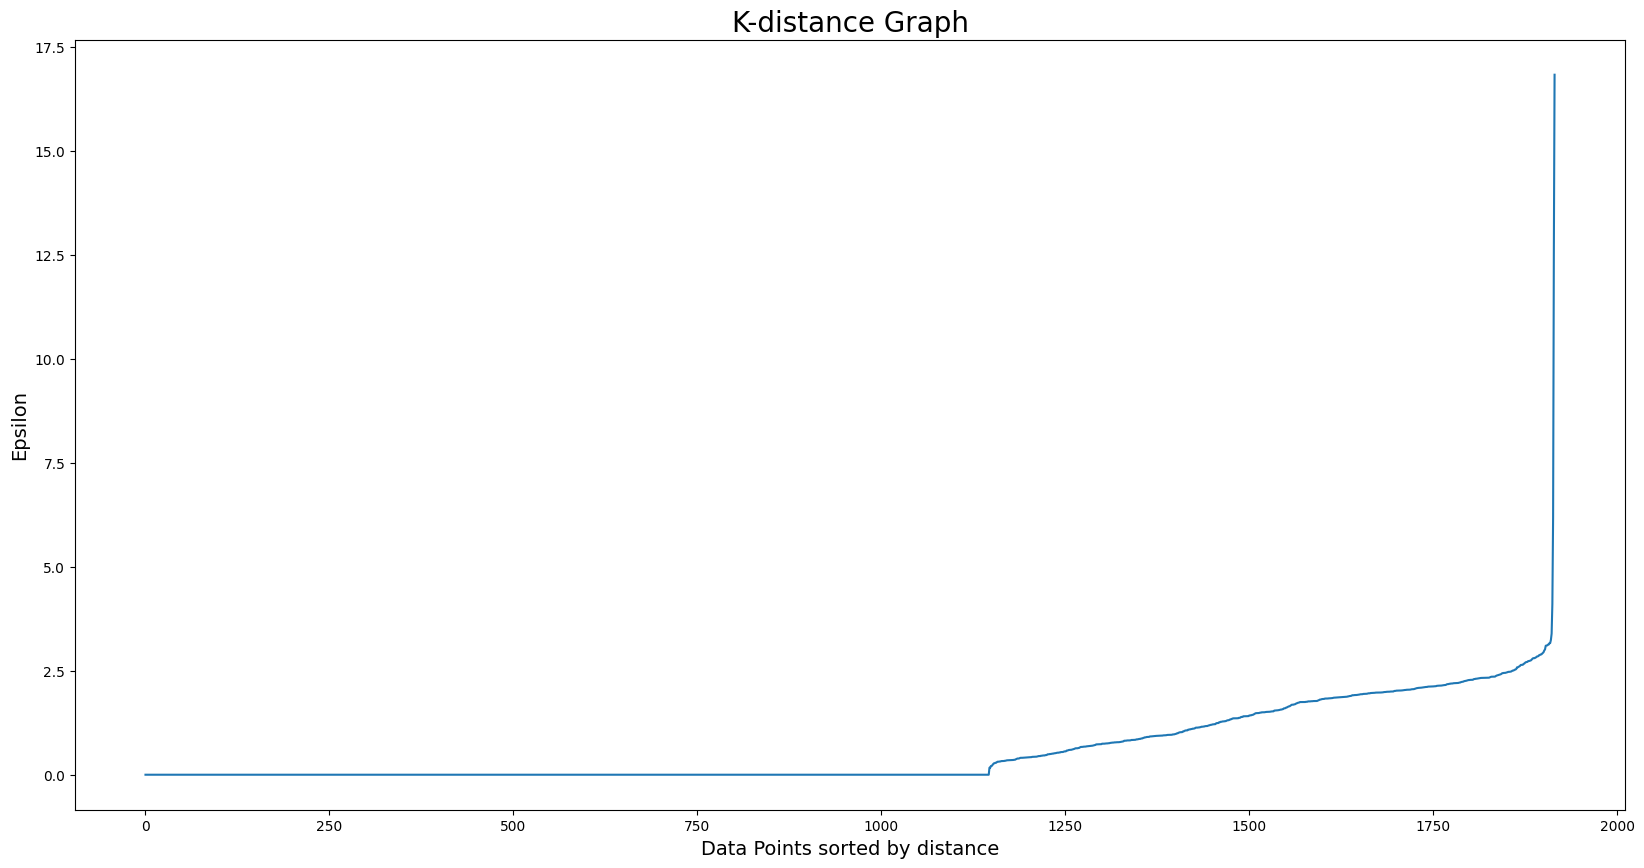

In [120]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [121]:

dbscan = DBSCAN(eps=3.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [122]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [123]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 123


In [124]:
df_7["Cluster_label"]=cluster_labels

In [126]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/7th_topic.csv")


In [127]:
df_7.to_csv(path_folder)

## ## DBSCAN -15

In [155]:
embeddings = []
for _, row in df_groups.get_group(15).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [156]:
df_15=df_groups.get_group(15)
vectors=embeddings

In [157]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [159]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [164]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [165]:
indices

array([[  18,   17,    9,    0],
       [  44,    1,  322,  327],
       [   2,  648,  646,  664],
       ...,
       [1121, 1122,  280,  687],
       [1122, 1121,  280,   81],
       [  41,   36,    7,    5]])

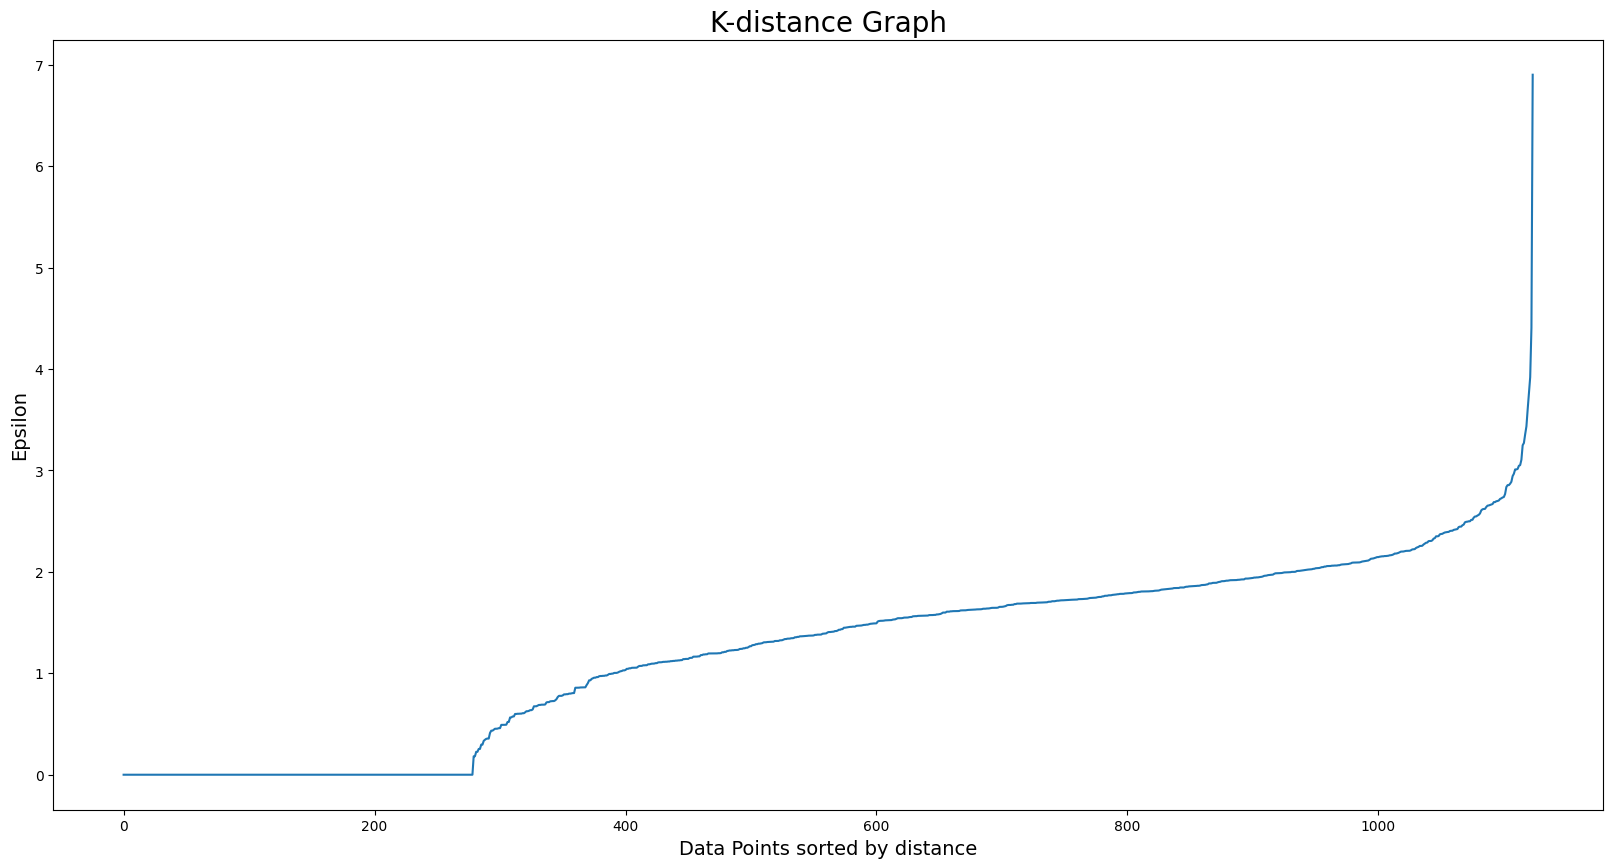

In [166]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [167]:

dbscan = DBSCAN(eps=3.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [168]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [169]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 108


In [170]:
df_15["Cluster_label"]=cluster_labels

In [171]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/15th_topic.csv")


In [172]:
df_15.to_csv(path_folder)

## DBSCAN -19

In [100]:
embeddings_19 = []
for _, row in df_groups.get_group(19).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings_19.append(cls_embedding)

In [101]:
df_19=df_groups.get_group(19)
vectors_19=embeddings_19

In [102]:
embeddings_arr_19=[i.numpy().flatten() for i in embeddings_19]

In [142]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [103]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs_19 = neigh.fit(embeddings_arr_19)


In [104]:
distances,indices=nbrs.kneighbors(embeddings_arr_19)


In [105]:
indices

array([[  0, 389,  36, 806],
       [389, 680, 422, 338],
       [680,  50,   0, 389],
       ...,
       [483, 496, 765, 559],
       [712, 581, 293, 285],
       [507, 464, 244, 678]], dtype=int64)

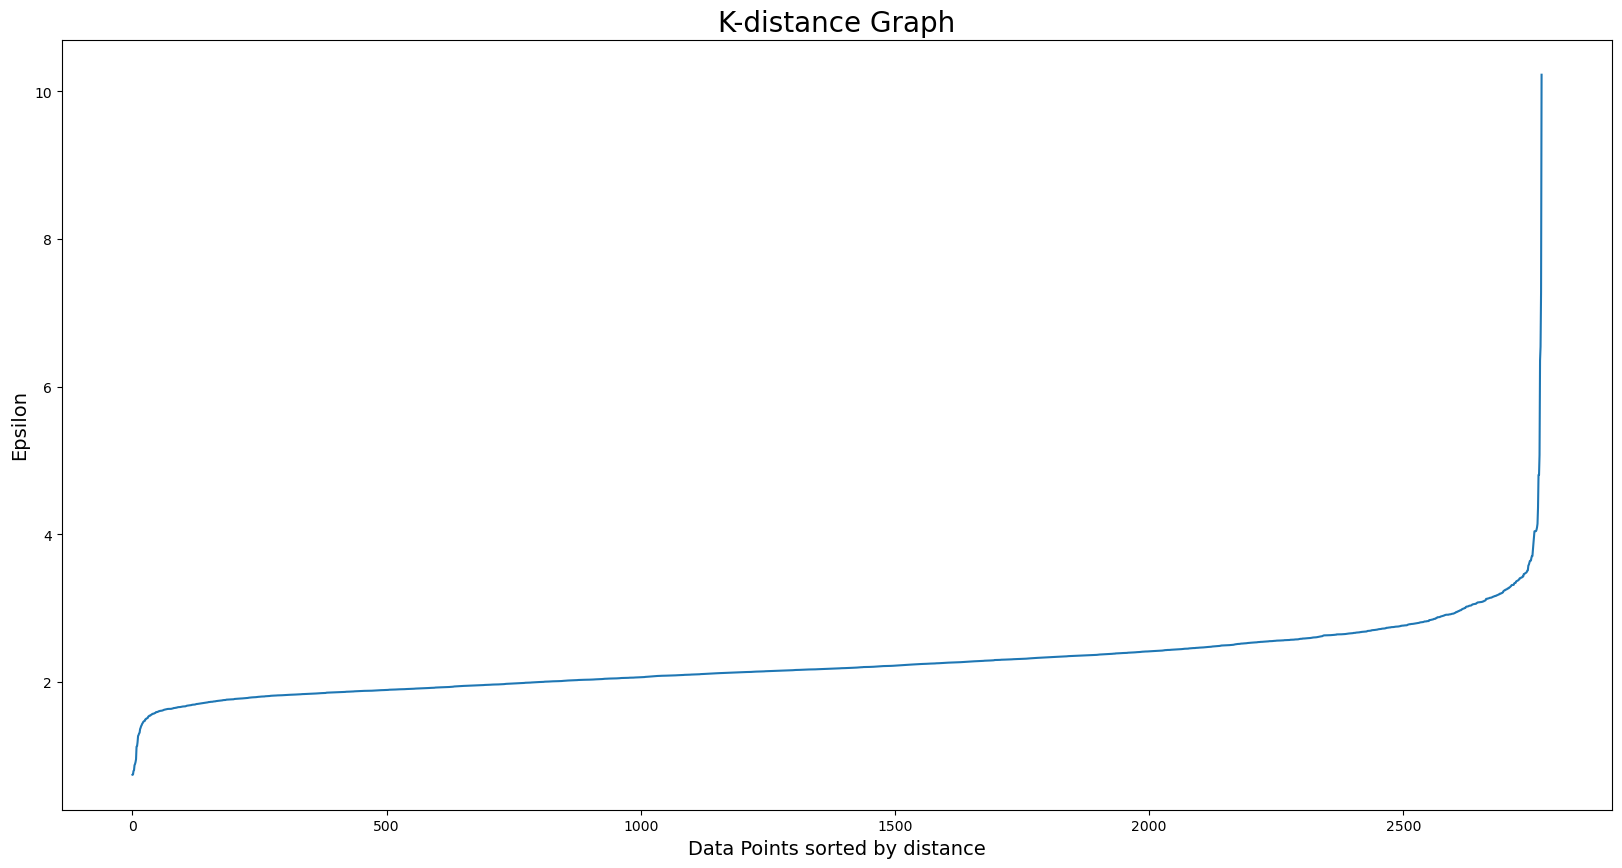

In [106]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [114]:

dbscan = DBSCAN(eps=2.0, min_samples=50)
dbscan.fit(embeddings_arr_19)
cluster_labels = dbscan.labels_
coords = embeddings_arr_19
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [115]:
cluster_labels

array([-1, -1, -1, ...,  0,  0, -1], dtype=int64)

In [109]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 883


In [116]:
df_19["Cluster_label"]=cluster_labels

In [117]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_19[df_19["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

Not enough clusters to calculate silhouette score


In [153]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/19th_topic.csv")


In [154]:
df_19.to_csv(path_folder)

## DBSCAN -11

In [163]:
embeddings = []
for _, row in df_groups.get_group(11).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [164]:
df_11=df_groups.get_group(11)
vectors=embeddings

In [165]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [166]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [167]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [168]:
indices

array([[   0, 4489,   38, 3460],
       [   5,    1,  462,  800],
       [   2,  643, 1054, 1057],
       ...,
       [4605, 2035,  826, 3810],
       [4606, 1667, 3975, 2875],
       [4607, 3478, 4269, 3451]], dtype=int64)

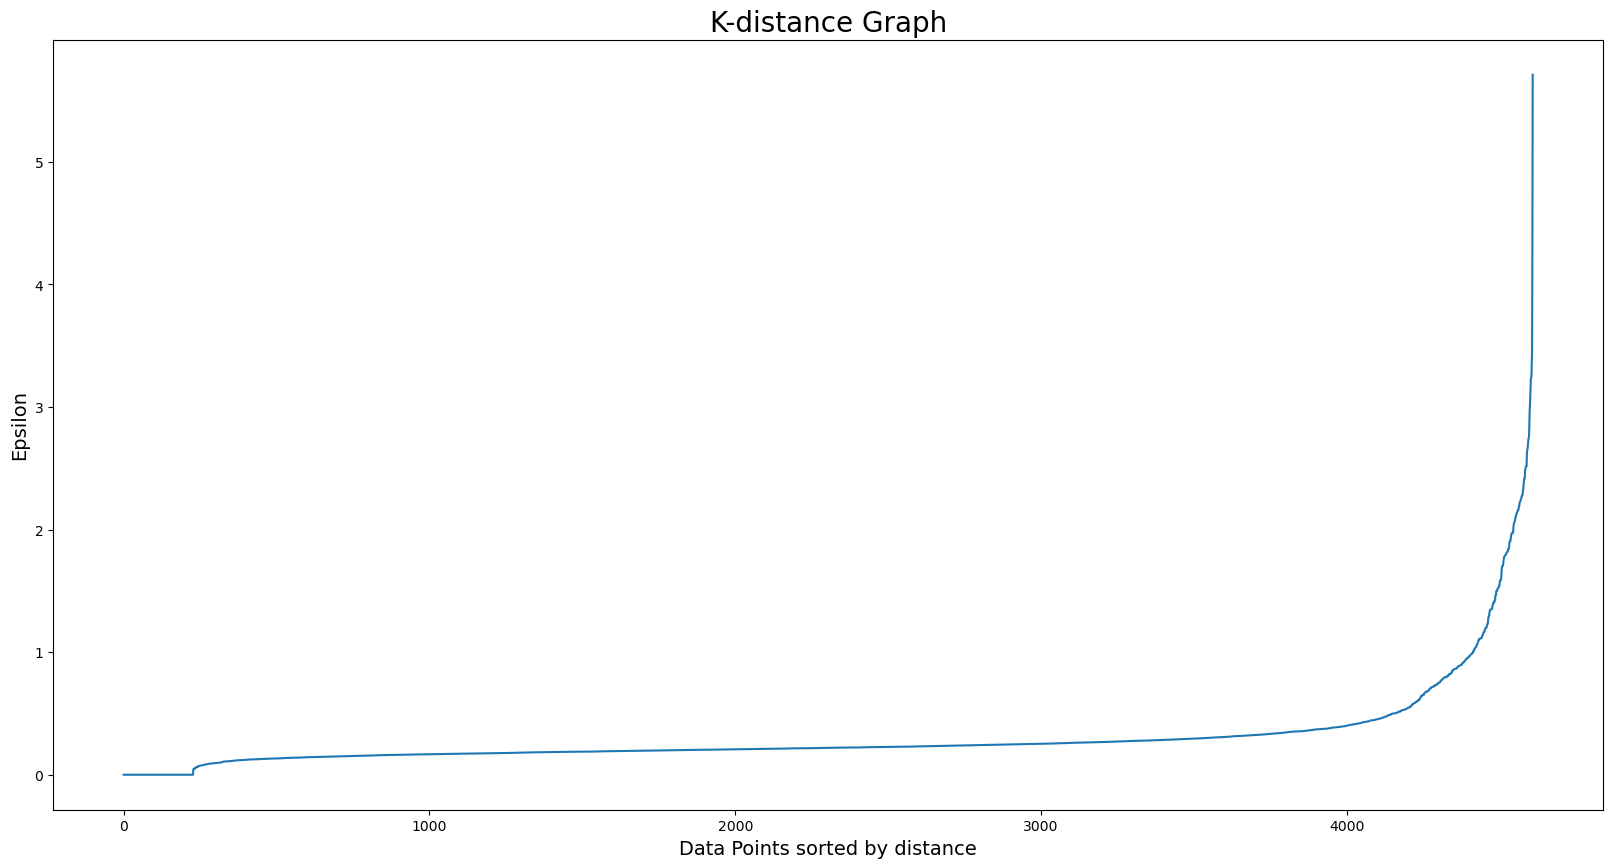

In [169]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [170]:

dbscan = DBSCAN(eps=0.5, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [171]:
cluster_labels

array([-1, -1, -1, ...,  0, -1,  0], dtype=int64)

In [172]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 5
Estimated no. of noise points: 1695


In [173]:
df_11["Cluster_label"]=cluster_labels

In [187]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/11th_topic.csv")


In [188]:
df_11.to_csv(path_folder)

## DBSCAN -12

In [189]:
embeddings = []
for _, row in df_groups.get_group(12).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [190]:
df_12=df_groups.get_group(12)
vectors=embeddings

In [191]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [192]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(std_emb)


NameError: name 'std_emb' is not defined

In [ ]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [ ]:
indices

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [191]:

dbscan = DBSCAN(eps=20.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [192]:
cluster_labels

array([ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [193]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 70


In [194]:
df_12["Cluster_label"]=cluster_labels

In [ ]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/12th_topic.csv)


In [ ]:
df_12.to_csv(path_folder)

## DBSCAN 9

In [ ]:
embeddings = []
for _, row in df_groups.get_group(9).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [184]:
df_9=df_groups.get_group(9)
vectors=embeddings

In [185]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [187]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(std_emb)
distances,indices=nbrs.kneighbors(embeddings_arr)

In [189]:
indices

array([[  0, 389],
       [  1,  11],
       [  2, 711],
       ...,
       [950, 258],
       [951, 379],
       [952, 515]], dtype=int64)

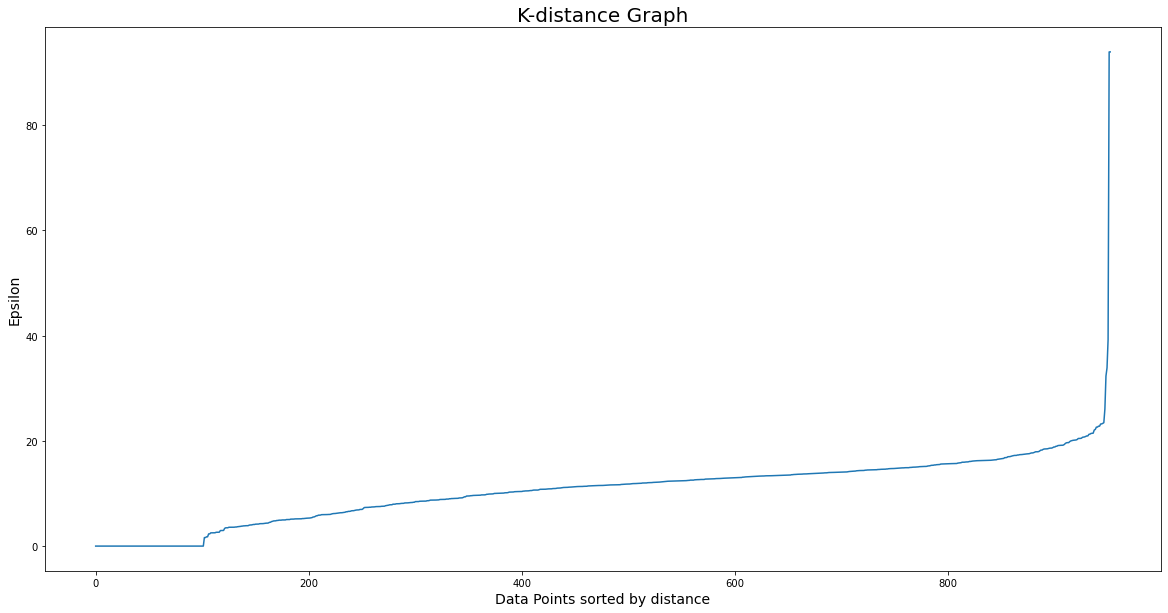

In [190]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [191]:

dbscan = DBSCAN(eps=22.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [192]:
cluster_labels

array([ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [193]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 70


In [194]:
df_9["Cluster_label"]=cluster_labels

In [ ]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/9th_topic.csv)


In [ ]:
df_9.to_csv(path_folder)

In [ ]:
6     41846
3     31042
14    25252
4     18335
8     15784
5     13528
10    12982
17    10520
16     9395
0      9306
1      8627


## DBSCAN 1

In [ ]:
for i in range(1,2):
    embeddings = []
    for _, row in df_groups.get_group(i).iterrows():
        sentence1 = row['V_COMMENTS_PROCESSED']
        cls_embedding = process_pair(sentence1)
        embeddings.append(cls_embedding)
    embeddings_arr=[i.numpy().flatten() for i in embeddings]
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(std_emb)
    distances,indices=nbrs.kneighbors(embeddings_arr)

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:

# 

## Local Outlier factor

In [80]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 1000
contamination = 0.4  # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(vectors)

# Print outliers
print("Outliers:")
for i, label in enumerate(outlier_labels):
    if label == -1:
        print(vectors[i])


NameError: name 'LocalOutlierFactor' is not defined

In [40]:
vectors[4009]

<1x14007 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [ ]:
# Define parameter grid
param_grid = {
    'n_neighbors': [500, 700,1000,1500],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(vectors)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(vectors, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


# using word embeddings - identifying the outliers - Not going to work

In [ ]:
# glove,word2vec cbow

In [10]:
# importing all necessary modules
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df["Tokens"].to_list()

[['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'year', 'birth', 'yob'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'date', 'birth', 'dob'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['match', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'nric'],
 ['match', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'date', 'birth', 'dob'],
 ['mismatch',
  'yobage',
  'comparison',
  'make',
  'customer',
  'yob',
  'bank',
  'kyc',
  'uco',
  'watchperson',
  'yob',
  'refinitive'],
 ['mismatch', 'identification', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'full', 'name', 'name', 'sound', 'similar'],
 ['mismatch

In [12]:
model1= gensim.models.Word2Vec(df["Tokens"].to_list(), min_count=1,
                                vector_size=100, window=5,sg=0)

In [13]:
# pickle.dump(,)
import pickle
pickle.dump(model1,open("word2vec.sav","wb"))

In [ ]:
# df_grp["Tokens"].get_group(1.0).apply(lambda x:np.array([model1.wv[i] for i in x]).shape)

In [1]:
df["Vect"]=df["Tokens"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

NameError: name 'df' is not defined

In [ ]:
df["Vect 2"]=df[" TF IDF Topic words"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

In [ ]:
import numpy as np
from numpy.linalg import norm

In [ ]:
df["sim_score"]=df[["Vect","Vect 2"]].apply(lambda x: cosine_similarity([x[0]],[x[1]]),axis=1)

In [ ]:
df["sim_score"]=df["sim_score"].apply(lambda x: x[0][0])
df["sim_score"]

In [66]:
df["sim_score"]=df["sim_score"].apply(lambda x: np.abs(x))

In [ ]:
# df[df["sim_score"].apply(lambda x: type(x)==np.ndarray)]["V_COMMENTS_2"].apply(lambda x: len(x))

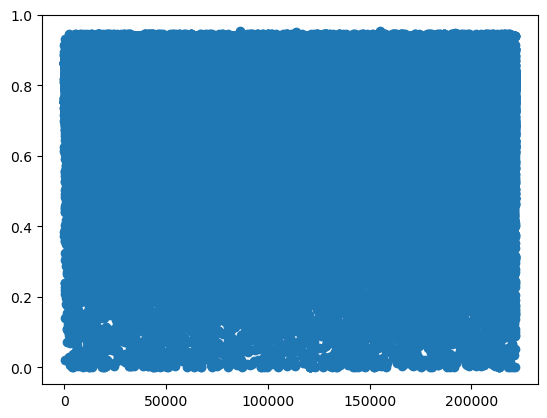

In [67]:
plt.scatter(df.index,df["sim_score"])

(array([ 1108.,  1595.,  2809.,  5421., 10566., 16970., 25518., 47586.,
        70774., 39184.]),
 array([5.57824969e-05, 9.53092448e-02, 1.90562707e-01, 2.85816170e-01,
        3.81069632e-01, 4.76323094e-01, 5.71576557e-01, 6.66830019e-01,
        7.62083481e-01, 8.57336944e-01, 9.52590406e-01]),
 <BarContainer object of 10 artists>)

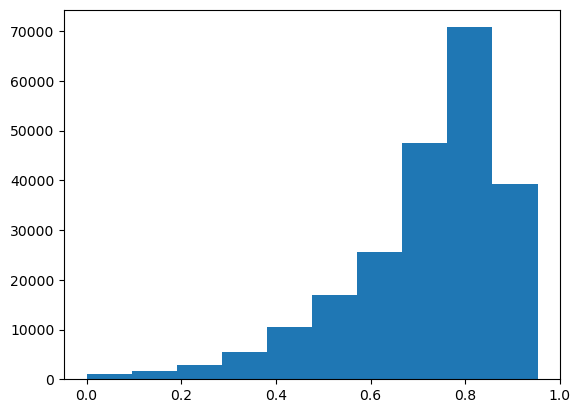

In [68]:
plt.hist(df["sim_score"])

{'whiskers': [<matplotlib.lines.Line2D at 0x275928f03a0>,
 'caps': [<matplotlib.lines.Line2D at 0x275928f0940>,
 'boxes': [<matplotlib.lines.Line2D at 0x275928f00d0>],
 'medians': [<matplotlib.lines.Line2D at 0x275928f0ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x275928fd220>],
 'means': []}

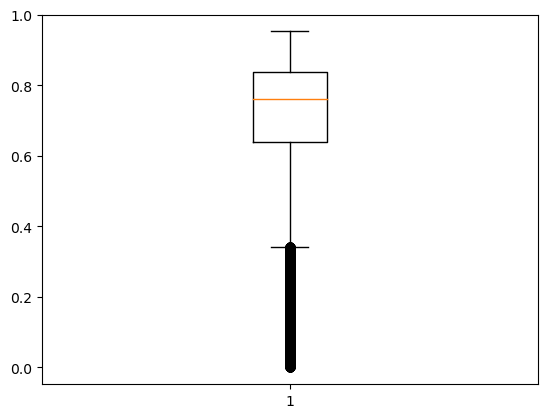

In [69]:
plt.boxplot(df["sim_score"])

In [70]:
q1,q2,q3=np.percentile(df["sim_score"],[25,50,75])
print(q1,q2,q3)

0.6396217346191406 0.7605907320976257 0.8385270833969116


In [73]:
y=q1-1.5*(q3-q1)
df[df["sim_score"].apply(lambda x: x<y)].to_csv("Outliers_word2vec_cbow.csv")

In [74]:
df1=df[df["sim_score"].apply(lambda x: x<y)]

In [75]:
df1["TF_tfidf_Topic_No"].value_counts()

1     1867
12    1065
15     920
14     905
18     742
2      683
17     318
10     316
13     283
19     265
7      262
9      179
8      110
6       91
5       80
0       77
16      14
Name: TF_tfidf_Topic_No, dtype: int64

In [ ]:
df[df_grp["sim_score"].transform(lambda x: (x-x.mean())/x.std()).apply(lambda x:True if abs(x)<x3 else False)]

# GlOVE , T-SNE , PCA - Not required

In [ ]:
# for i in range(10):
#      plt.boxplot(df_grp["sim_score"].get_group(int(i)))
for i in list(df_grp.groups.keys()):
    print(i)
    print(df_grp["sim_score"].get_group(i).mean())

In [ ]:
### PCA

In [ ]:
from sklearn.decomposition import PCA
labels = []
tokens = []
for word in model1.wv.index_to_key:
        tokens.append(model1.wv[word])
        labels.append(word)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(tokens)




In [ ]:
# df_1=df_grp.get_group(1.0)
# df_grp["Topic words"]

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [ ]:
# Convert GloVe format to word2vec format
glove_input_file = 'glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B/glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
# Load the converted model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)



# Example usage
vector = glove_model['example']
similar_words = glove_model.most_similar('example')

print("Vector representation of 'example':", vector)
print("Similar words to 'example':", similar_words)

In [ ]:
### T-SNE & PCA

In [ ]:
def tsne_plot():
    labels = []
    tokens = []
    
    # Extracting words and their vectors from our trained model1 
    for word in model1.wv.index_to_key:
        tokens.append(model1.wv[word])
        labels.append(word)
    
    # Train t-SNE 
    tsne_model1 = TSNE(perplexity=45, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model1.fit_transform(tokens)
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()
# Words that occur atleast











In [ ]:
# tsne_plot()

In [ ]:
len(tokens)

In [ ]:
vectors = vectorizer.fit_transform(df["V_COMMENTS_2"])

In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(vectors)
pca.components_

In [ ]:
# Step 1: Create word vectors for each word in the text data
word_vectors = []
for sentence in text_data:
    tokens = sentence.split()
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if vectors:
        word_vectors.append(np.mean(vectors, axis=0))

# Step 2: Apply PCA
word_vectors = np.array(word_vectors)
num_components = 2  # Choose the number of components
pca = PCA(n_components=num_components)
word_vectors_pca = pca.fit_transform(word_vectors)

# Step 3: Analysis
# Let's print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Step 4: Visualize the transformed data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(word_vectors_pca)):
    plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1], label=f"Sentence {i+1}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA on Word2Vec Embeddings")
plt.show()

